# Introduction

Setting up the environment for the project to be run.

In [198]:
!nvidia-smi

Sat Mar  8 20:49:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             33W /  250W |    4413MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [199]:
!pip install -q gdown inference-gpu
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done


In [200]:
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /kaggle/working/121364_0.mp4
100%|███████████████████████████████████████| 17.2M/17.2M [00:00<00:00, 105MB/s]


In [201]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"  

In [202]:
import io
import sys
import cv2
import umap
import torch
import logging
import numpy as np
import supervision as sv

from inference import get_model
from kaggle_secrets import UserSecretsClient
from google.colab import userdata 
from tqdm import tqdm
from more_itertools import chunked
from sklearn.cluster import KMeans
from typing import Optional
from transformers import AutoProcessor, SiglipVisionModel
from sports.common.team import TeamClassifier
from sports.common.view import ViewTransformer
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_paths_on_pitch,
    draw_pitch_voronoi_diagram
)


In [204]:
SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"
TARGET_VIDEO_PATH = "/kaggle/working/121364_0_result.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
STRIDE = 30

In [205]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17, outline_thickness=1
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)


In [206]:
user_secrets = UserSecretsClient()
ROBOFLOW_API_KEY = user_secrets.get_secret("Roboflow")

# Object/Keypoint Detection & Team Classification:

## Load ObjectDetection Model:

In [207]:
DETECTION_MODEL_ID = "football-detection-ysgxf/3"
DETECTION_MODEL = get_model(
    model_id=DETECTION_MODEL_ID, 
    api_key=ROBOFLOW_API_KEY,
)

## Load Key Point Detection Model:

In [208]:
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi-jufj9/1"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

## Load Classification Model

In [209]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

### Using the Detection Model I have trained, fine-tune the Pre-trained Classification Model:

In [210]:
def extract_crops(source_video_path: str):
    # Stride to skip every 29 frames and get the 30th one
    frame_generator = sv.get_video_frames_generator(source_path=source_video_path, stride=STRIDE)
    crops = []
    for frame_sample in tqdm(frame_generator, desc='Collecting crops'):
        result = DETECTION_MODEL.infer(frame_sample, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops += [
            sv.crop_image(frame_sample, xyxy) 
            for xyxy in detections.xyxy
        ]
    return crops

Number of crops: 478


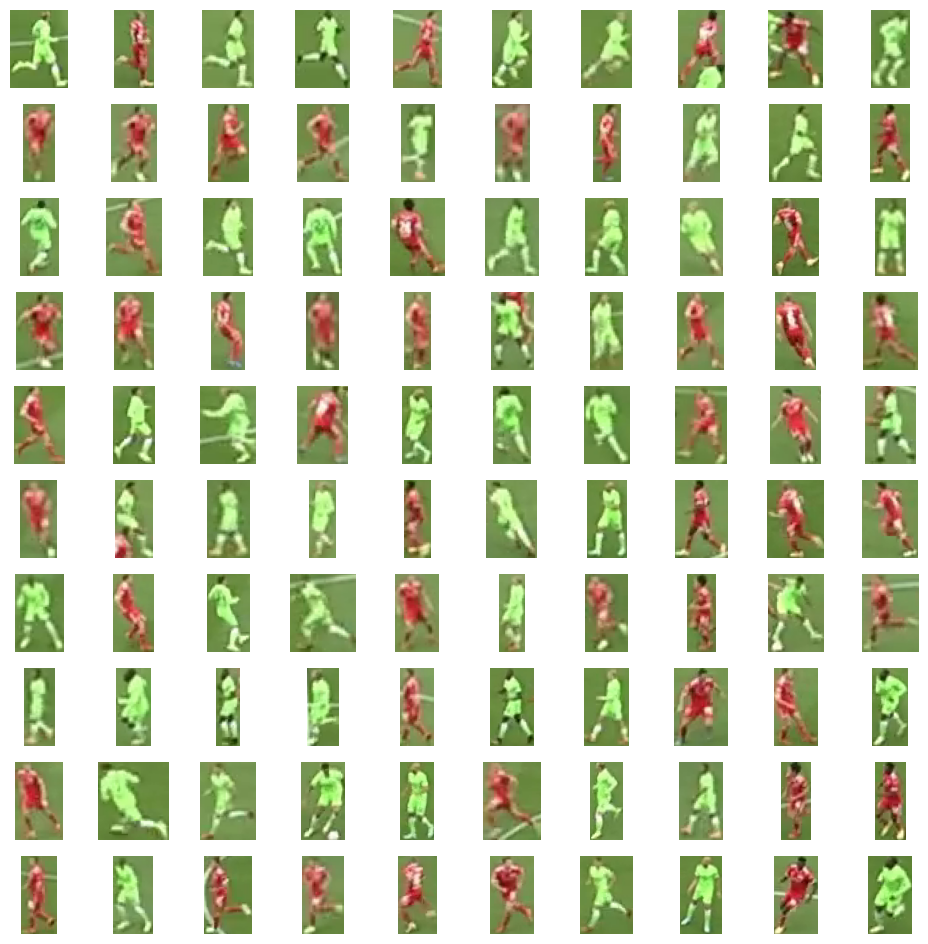

In [211]:
crops = extract_crops(SOURCE_VIDEO_PATH)
print('Number of crops:', len(crops))
sv.plot_images_grid(crops[:100], grid_size=[10,10])

In [212]:
BATCH_SIZE = 32
# Convert from numpy arrays (OpenCV) to Pillow images for SigLIP Model
crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = list(chunked(crops, BATCH_SIZE))
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='Embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)
print('Embeddings shape:', data.shape)

Embedding extraction: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]

Embeddings shape: (478, 768)


In [213]:
REDUCER = umap.UMAP(n_components=3)  # Reduce to 3D space
CLUSTERING_MODEL = KMeans(n_clusters=2)
projections = REDUCER.fit_transform(data)
print('Projections shape:', projections.shape)

Projections shape: (478, 3)


In [214]:
clusters = CLUSTERING_MODEL.fit_predict(projections)
print('Clusters:', clusters)

Clusters: [1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1
 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0
 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1
 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0
 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0
 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1
 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1
 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1
 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0
 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1]


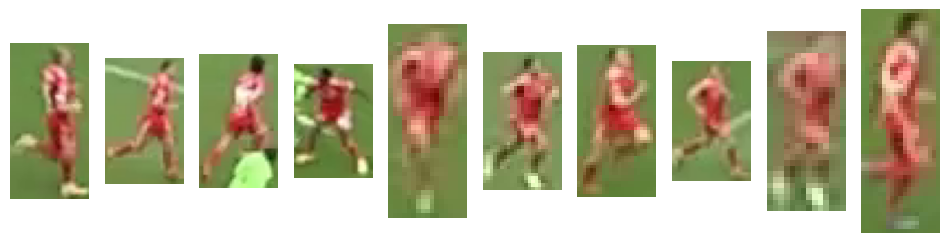

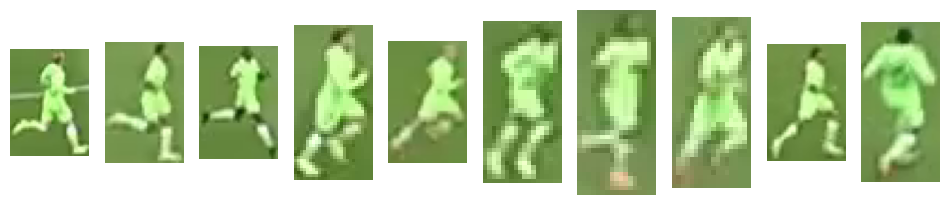

In [215]:
team_0 = [crop for crop, cluster in zip(crops, clusters) if cluster == 0]
team_1 = [crop for crop, cluster in zip(crops, clusters) if cluster == 1]
sv.plot_images_grid(team_0[:10], grid_size=[1,10])
sv.plot_images_grid(team_1[:10], grid_size=[1,10])

In [216]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='Collecting crops for team classification'):
    result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

Embedding extraction: 18it [00:04,  3.95it/s]


### Models Loaded and Fine-tuned. Running code:

In [217]:
def resolve_goalkeepers_team_id(players: sv.Detections, goalkeepers: sv.Detections) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

In [218]:
def player_classification(frame):
    result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    
    ball_detections = detections[detections.class_id == BALL_ID]
    other_detections = detections[detections.class_id != BALL_ID]
    
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
    other_detections = tracker.update_with_detections(detections=other_detections)
    
    goalkeepers_detections = other_detections[other_detections.class_id == GOALKEEPER_ID]
    players_detections = other_detections[other_detections.class_id == PLAYER_ID]
    referees_detections = other_detections[other_detections.class_id == REFEREE_ID]
    
    player_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(player_crops)
    
    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)
    
    referees_detections.class_id -= 1
    
    other_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections, referees_detections
    ])
    
    labels = [f"#{tracker_id}" for tracker_id in other_detections.tracker_id]
    other_detections.class_id = other_detections.class_id.astype(int)
    
    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=other_detections)
    annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=other_detections, labels=labels)
    return detections, annotated_frame

Embedding extraction: 1it [00:00,  6.92it/s]


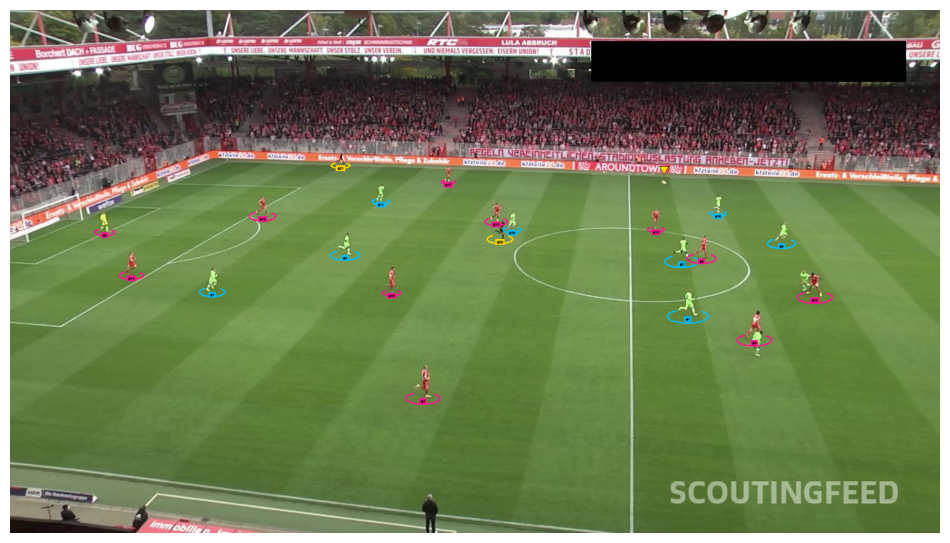

In [219]:
tracker = sv.ByteTrack()
tracker.reset()

frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))
_, output = player_classification(frame)
sv.plot_image(output)

### Detecting Pitch for Homography:

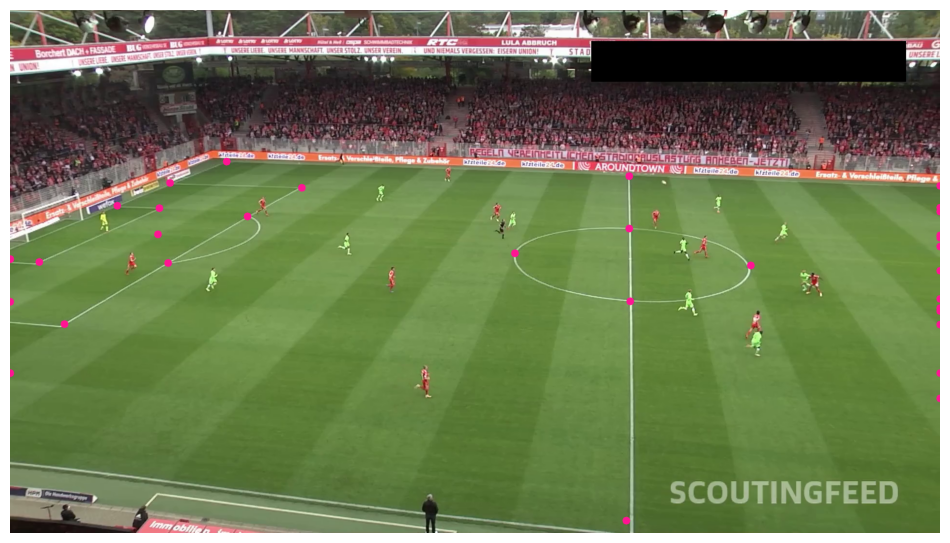

In [220]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=key_points)

sv.plot_image(annotated_frame)

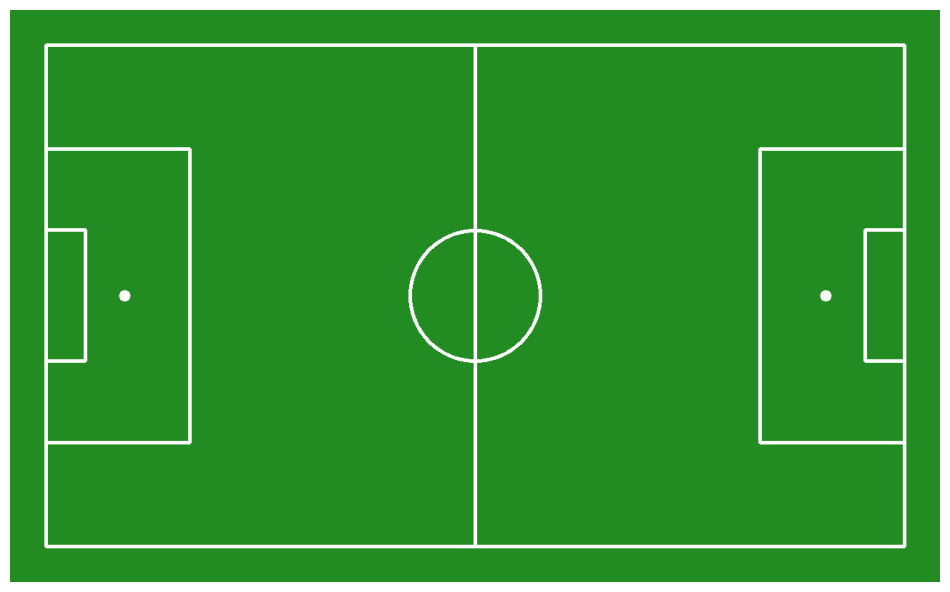

In [221]:
CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

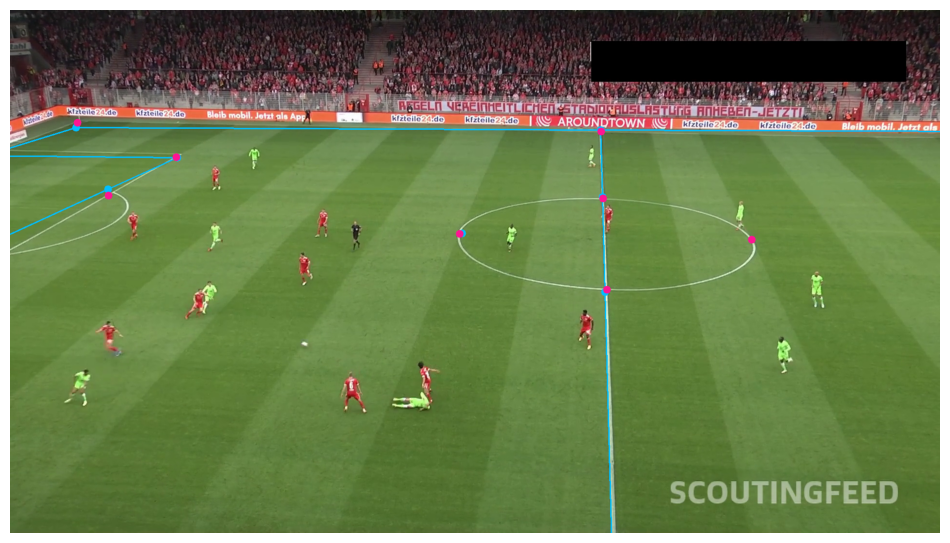

In [222]:
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, 
    edges=CONFIG.edges
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8
)

frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200))

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(scene=annotated_frame, key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [262]:
def homography_pitch(detections, frame):    
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)
    
    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
    
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    with contextlib.redirect_stderr(io.StringIO()):
        players_detections.class_id = team_classifier.predict(players_crops)
    
    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
    
    referees_detections.class_id -= 1
    
    all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])
    
    labels = [f"#{tracker_id}" for tracker_id in all_detections.tracker_id]
    
    all_detections.class_id = all_detections.class_id.astype(int)
    
    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
    annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
    last_defender = find_last_defender(players_detections)
    # sv.plot_image(annotated_frame)
    players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])
    
    # Detect pitch key points
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)
    
    # Project ball, players and referees on pitch
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
    )
    transformer_inverse = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
    )
    
    
    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)
    
    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_players_xy = transformer.transform_points(points=players_xy)
    
    referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_referees_xy = transformer.transform_points(points=referees_xy)
    
    # Visualize video game-style radar view
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_referees_xy,
        face_color=sv.Color.from_hex('FFD700'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    return annotated_frame

In [235]:
def calculate_distances(xy, x_coordinates, y_coordinates):
    return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                   (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

In [236]:
def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
    ) -> np.ndarray:

    if pitch is None:
        pitch = draw_pitch(config=config, padding=padding, scale=scale)

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((scaled_width + 2 * padding, scaled_length + 2 * padding))

    y_coordinates -= padding
    x_coordinates -= padding

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    steepness = 15  # Sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    for c in range(3):
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] + (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

Embedding extraction: 1it [00:00,  6.93it/s]
Embedding extraction: 1it [00:00,  6.83it/s]


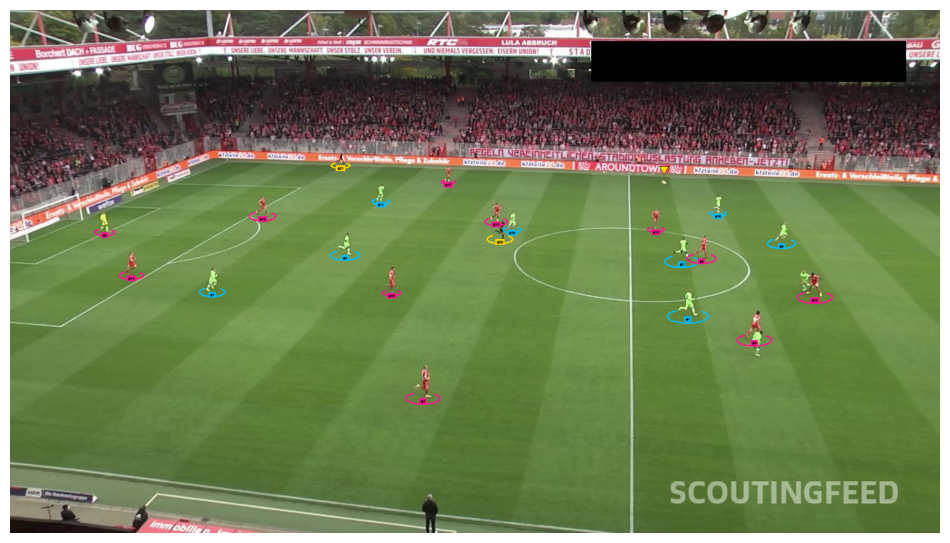

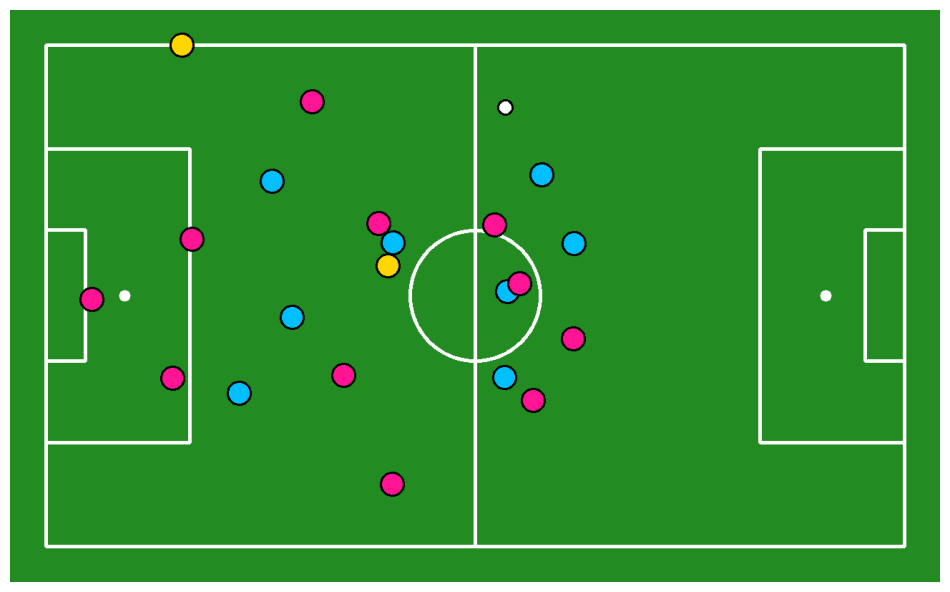

In [237]:
tracker = sv.ByteTrack()
tracker.reset()

frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))
detections, output = player_classification(frame)
# sv.plot_image(output)
sv.plot_image(homography_pitch(detections, frame))

In [238]:
annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 21 but corresponding boolean dimension is 18

In [ ]:
annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)

In [285]:
def find_last_defender(player_detections):
# Step 1: Identify the last defenders for both teams
    last_defender = {}
    potential_offside = []
    team_players_0 = players_detections[(players_detections.class_id == 0)]
    team_players_0_xy = team_players_0.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_players_1 = players_detections[(players_detections.class_id == 1)]
    team_players_1_xy = team_players_1.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    # Step 3: Transform coordinates to pitch space
    pitch_team0_players_xy = transformer.transform_points(points=team_players_0_xy)
    pitch_team1_players_xy = transformer.transform_points(points=team_players_1_xy)
    # Step 4: Determine the last defender for this team
    if len(pitch_team_players_xy) > 0:
        if np.mean(pitch_team0_players_xy[:, 0]) < np.mean(pitch_team1_players_xy[:, 0]):
            last_defender[0] = np.min(pitch_team0_players_xy[:, 0])
            last_defender[1] = np.max(pitch_team1_players_xy[:, 0])
            for pos, tracker in zip(pitch_team0_players_xy, team_players_0.tracker_id):
                if pos[0] > last_defender[1]:
                    potential_offside.append(tracker)
            for pos, tracker in zip(pitch_team1_players_xy, team_players_1.tracker_id):
                if pos[0] < last_defender[0]:
                    potential_offside.append(tracker)
            
        else:
            last_defender[0] = np.max(pitch_team0_players_xy[:, 0])
            last_defender[1] = np.min(pitch_team1_players_xy[:, 0])
            for pos, tracker in zip(pitch_team0_players_xy, team_players_0.tracker_id):
                if pos[0] < last_defender[1]:
                    potential_offside.append(tracker)
            for pos, tracker in zip(pitch_team1_players_xy, team_players_1.tracker_id):
                if pos[0] > last_defender[0]:
                    potential_offside.append(tracker)

        
    else:
        last_defender = None  # No defenders detected
    
    return last_defender, potential_offside

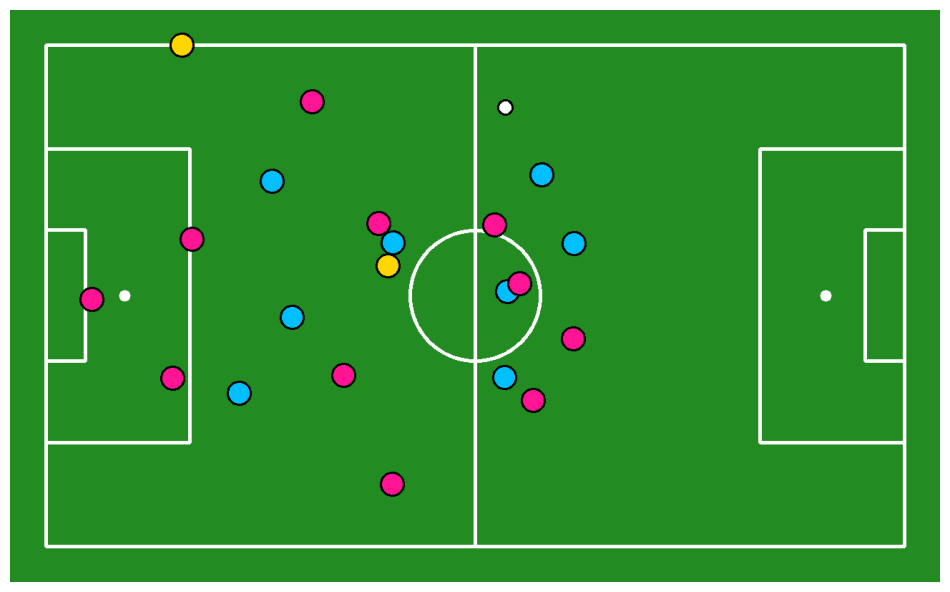

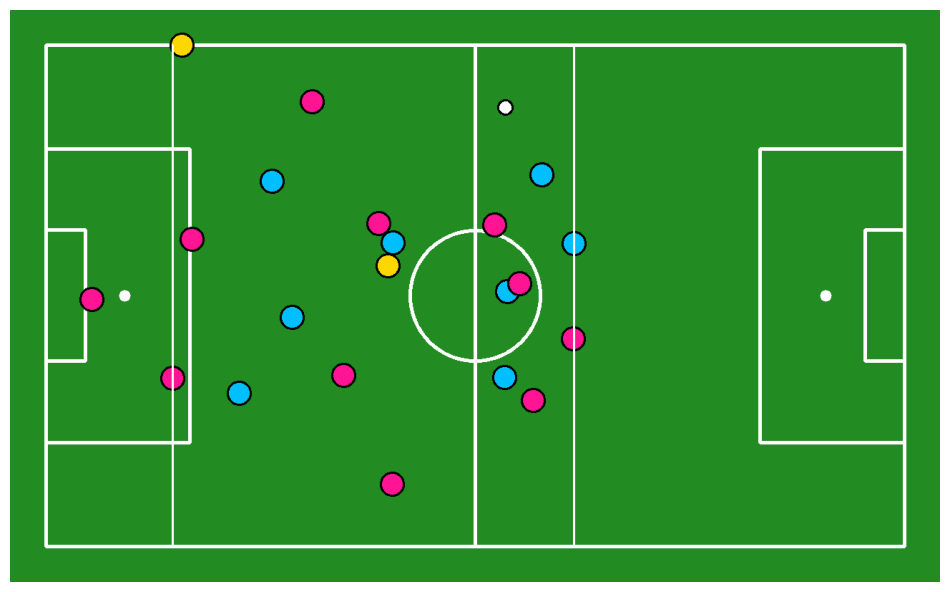

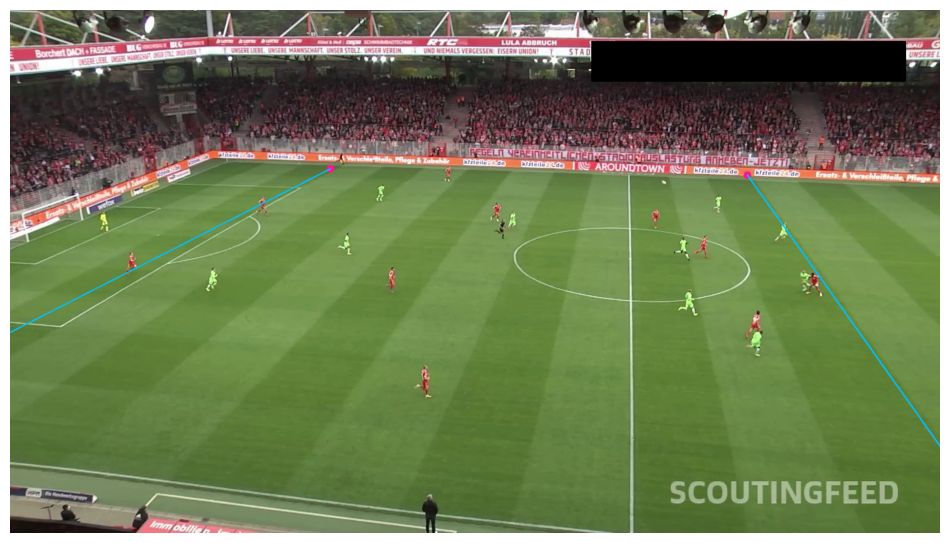

[]


In [289]:
SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

tracker = sv.ByteTrack()
tracker.reset()

frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))

result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)
    
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
with contextlib.redirect_stderr(io.StringIO()):
    players_detections.class_id = team_classifier.predict(players_crops)

last_defender_positions, potential_offside = find_last_defender(players_detections)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

labels = [f"#{tracker_id}" for tracker_id in all_detections.tracker_id]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
# sv.plot_image(annotated_frame)
players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

# Detect pitch key points
result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# Project ball, players and referees on pitch
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
source=frame_reference_points,
target=pitch_reference_points
)
transformer_inverse = ViewTransformer(
source=pitch_reference_points,
target=frame_reference_points
)


frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# Visualize video game-style radar view
annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame
)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)

x_coord = last_defender_positions[0]
vertical_line_path = np.array([
    [x_coord, 0],
    [x_coord, CONFIG.width]
])

annotated_frame = draw_paths_on_pitch(config=CONFIG, paths=[vertical_line_path], pitch=annotated_frame)
x_coord = last_defender_positions[1]

vertical_line_path = np.array([
    [x_coord, 0],
    [x_coord, CONFIG.width]
])
annotated_frame = draw_paths_on_pitch(config=CONFIG, paths=[vertical_line_path], pitch=annotated_frame)

sv.plot_image(annotated_frame)

offside_points = np.array([[last_defender_positions[0],0],
                           [last_defender_positions[0], CONFIG.width],
                           [last_defender_positions[1],0],
                           [last_defender_positions[1], CONFIG.width]])

frame_coordinates = transformer_inverse.transform_points(points=offside_points)
key_points = sv.KeyPoints(xy=frame_coordinates[np.newaxis, ...])

edges = [(0, 3), (1, 2)]
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, 
    edges=edges
)

annotated_frame = vertex_annotator.annotate(scene=frame, key_points=key_points)
annotated_frame = edge_annotator.annotate(scene=frame, key_points=key_points)

sv.plot_image(annotated_frame)
print(potential_offside)

In [ ]:
# Only video of detection
tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        _,  output =  player_classification(frame)
        video_sink.write_frame(output)

print('Video Made.')

In [290]:
def lighten_color(hex_color, factor=0.3):
    # Convert hex to RGB tuple
    rgb = tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    # Increase each channel by the factor (ensuring not to exceed 255)
    lighter_rgb = tuple(min(255, int(c + (255 - c) * factor)) for c in rgb)
    # Convert back to hex
    return '#{:02x}{:02x}{:02x}'.format(*lighter_rgb)


In [298]:
# from typing import List, Optional


# # resolves which player is currently in ball possession based on player-ball proximity
# def get_player_in_possession(
#     player_detections: list,
#     ball_detections: list,
#     proximity: int
#     ) -> Optional[list]:
#     if len(ball_detections) != 1:
#         return None
#     ball_detection = ball_detections[0]
#     for player_detection in player_detections:
#         if player_detection.rect.pad(proximity).contains_point(point=ball_detection.rect.center):
#             return player_detection

In [305]:
def get_player_in_possession(player_detections, ball_detections, proximity):
    # Assume ball_detections.xyxy is an array of bounding boxes
    ball_box = ball_detections.xyxy[0]
    # Convert ball_box tuple to a Rect object (if available)
    ball_rect = sv.Rect.from_xyxy(ball_box)  # check your library's API
    ball_center = ball_rect.center

    for box in player_detections.xyxy:
        player_rect = sv.Rect.from_xyxy(box)
        padded_rect = player_rect.pad(proximity)
        if padded_rect.contains_point(point=ball_center):
            return player_rect  # or the original box
    return None


In [300]:

# black
MARKER_CONTOUR_COLOR_HEX = "000000"
# MARKER_CONTOUR_COLOR = Color.from_hex_string(MARKER_CONTOUR_COLOR_HEX)

# red
PLAYER_MARKER_FILL_COLOR_HEX = "FF0000"
# PLAYER_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER_MARKER_FILL_COLOR_HEX)

# green
BALL_MERKER_FILL_COLOR_HEX = "00FF00"
# BALL_MARKER_FILL_COLOR = Color.from_hex_string(BALL_MERKER_FILL_COLOR_HEX)

MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

# distance in pixels from the player's bounding box where we consider the ball is in his possession
PLAYER_IN_POSSESSION_PROXIMITY = 30

In [ ]:
# calculates coordinates of possession marker
def calculate_marker(anchor: Point) -> np.ndarray:
    x, y = anchor.int_xy_tuple
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))

In [307]:
def get_player_in_possession(player_detections, ball_detections, proximity):
    # Assume ball_detections.xyxy is an array of bounding boxes
    ball_box = ball_detections.xyxy[0]  # first ball detection
    ball_center = ((ball_box[0] + ball_box[2]) / 2, (ball_box[1] + ball_box[3]) / 2)
    
    for box in player_detections.xyxy:
        # Create a padded bounding box
        padded_box = [
            box[0] - proximity,
            box[1] - proximity,
            box[2] + proximity,
            box[3] + proximity
        ]
        # Check if ball_center is inside padded_box
        if (padded_box[0] <= ball_center[0] <= padded_box[2] and
            padded_box[1] <= ball_center[1] <= padded_box[3]):
            return box  # or return more info as needed
    return None


In [310]:
# Creates final video output
import contextlib
import time
OUTPUT_VIDEO_PATH = "output_video.mp4"
TARGET_VIDEO_PATH = "result5.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
# # Ellipse annotator for offside players (using the lighter colors)
# offside_ellipse_annotator = sv.EllipseAnnotator(
#     color=sv.ColorPalette.from_hex(['#34eb49', '#64f5f0']),
#     thickness=2
# )
        
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

team_colors=['#00BFFF', '#FF1493']
# This example assumes that players_detections.class_id indicates the team index (0 or 1)
offside_colors = []
for team_id in offside_detections.class_id:
    base_color = team_colors[int(team_id)]
    offside_colors.append(lighten_color(base_color, factor=0.3))

offside_palette = sv.ColorPalette.from_hex(offside_colors)

# Ellipse annotator for offside players (using the lighter colors)
offside_ellipse_annotator = sv.EllipseAnnotator(
    color=offside_palette,
    thickness=2
)

tracker = sv.ByteTrack()
tracker.reset()

CONFIG = SoccerPitchConfiguration()

pitch_frame = draw_pitch(CONFIG)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
fps = 30
frame_height, frame_width = pitch_frame.shape[:2]
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink1 = sv.VideoSink("/kaggle/working/offside.mp4", video_info=video_info)
video_writer1 = cv2.VideoWriter('/kaggle/working/offside_pitch.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
# video_writer2 = cv2.VideoWriter('/kaggle/working/output_video2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
# video_writer3 = cv2.VideoWriter('/kaggle/working/output_video3.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
start_time = time.time()
with video_sink1:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)
        
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
        
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        
        with contextlib.redirect_stderr(io.StringIO()):
            players_detections.class_id = team_classifier.predict(players_crops)
            
        last_defender_positions, potential_offsides = find_last_defender(players_detections)
        
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
        
        referees_detections.class_id -= 1
        
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])
        
        labels = [f"#{tracker_id}" for tracker_id in all_detections.tracker_id]
        all_detections.class_id = all_detections.class_id.astype(int)




        # Create a mask for players whose tracker_id is in potential_offsides
        offside_mask = np.isin(all_detections.tracker_id, potential_offsides)
        offside_detections = all_detections[offside_mask]
        non_offside_detections = all_detections[~offside_mask]
        player_in_possession_detection = get_player_in_possession(
            player_detections=players_detections,
            ball_detections=ball_detections,
            proximity=PLAYER_IN_POSSESSION_PROXIMITY)

        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=non_offside_detections)
        annotated_frame = offside_ellipse_annotator.annotate(scene=annotated_frame, detections=offside_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
        if player_in_possession_detection is not None:
            p = [player_in_possession_detection]
            # p.xyxy = sv.pad_boxes(xyxy=p.xyxy, px=10)
            annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=p)
        
        
        players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)
        
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG.vertices)[filter]
        
        transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )
        transformer_inverse = ViewTransformer(
            source=pitch_reference_points,
            target=frame_reference_points
        )
        
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)
        
        players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = transformer.transform_points(points=players_xy)
        
        referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = transformer.transform_points(points=referees_xy)
        
        annotated_pitch = draw_pitch(CONFIG)
        annotated_pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=annotated_pitch
        )
        annotated_pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_pitch
        )
        annotated_pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_pitch
        )
        annotated_pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_referees_xy,
            face_color=sv.Color.from_hex('FFD700'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_pitch
        )
        
        video_writer1.write(annotated_pitch)
        
        offside_points = np.array([[last_defender_positions[0],0],
                                   [last_defender_positions[0], CONFIG.width],
                                   [last_defender_positions[1],0],
                                   [last_defender_positions[1], CONFIG.width]])
        
        frame_coordinates = transformer_inverse.transform_points(points=offside_points)
        key_points = sv.KeyPoints(xy=frame_coordinates[np.newaxis, ...])
        
        edges = [(0, 3), (1, 2)]
        edge_annotator = sv.EdgeAnnotator(
            color=sv.Color.from_hex('#00BFFF'),
            thickness=2, 
            edges=edges
        )
        
        annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=key_points)
        annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=key_points)
        # sv.plot_image(annotated_frame)
        video_sink1.write_frame(annotated_frame)

        # annotated_frame = homography_pitch(detections, frame)
        
        # x_coord = last_defender_positions[0]
        # vertical_line_path = np.array([
        #     [x_coord, 0],
        #     [x_coord, CONFIG.width]
        # ])
        
        # annotated_frame = draw_paths_on_pitch(config=CONFIG, paths=[vertical_line_path], pitch=annotated_frame)
        # x_coord = last_defender_positions[1]
        
        # vertical_line_path = np.array([
        #     [x_coord, 0],
        #     [x_coord, CONFIG.width]
        # ])
        # annotated_frame = draw_paths_on_pitch(config=CONFIG, paths=[vertical_line_path], pitch=annotated_frame)
        # video_writer1.write(annotated_frame)
        
video_writer1.release()
print("--- %s seconds ---" % (time.time() - start_time))


  1%|          | 7/750 [00:03<05:39,  2.19it/s]


AttributeError: 'list' object has no attribute 'get_anchors_coordinates'

In [ ]:
# Creates final video output
OUTPUT_VIDEO_PATH = "output_video.mp4"
TARGET_VIDEO_PATH = "result5.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

CONFIG = SoccerPitchConfiguration()

pitch_frame = draw_pitch(CONFIG)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
fps = 30
frame_height, frame_width = pitch_frame.shape[:2]
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink1 = sv.VideoSink("/kaggle/working/sink1.mp4", video_info=video_info)
video_writer1 = cv2.VideoWriter('/kaggle/working/output_video1.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
video_writer2 = cv2.VideoWriter('/kaggle/working/output_video2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
video_writer3 = cv2.VideoWriter('/kaggle/working/output_video3.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

with video_sink1:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)
        
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
        
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)
        
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
        
        referees_detections.class_id -= 1
        
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])
        
        labels = [f"#{tracker_id}" for tracker_id in all_detections.tracker_id]
        all_detections.class_id = all_detections.class_id.astype(int)
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
        
        video_sink1.write_frame(annotated_frame)
        
        players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])
        
        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)
        
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG.vertices)[filter]
        
        transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )
        
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)
        
        players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = transformer.transform_points(points=players_xy)
        
        referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = transformer.transform_points(points=referees_xy)
        
        annotated_frame = draw_pitch(CONFIG)
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_referees_xy,
            face_color=sv.Color.from_hex('FFD700'),
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=annotated_frame
        )
        
        video_writer1.write(annotated_frame)
        
        annotated_frame = draw_pitch(CONFIG)
        annotated_frame = draw_pitch_voronoi_diagram(
            config=CONFIG,
            team_1_xy=pitch_players_xy[players_detections.class_id == 0],
            team_2_xy=pitch_players_xy[players_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_frame
        )
        video_writer2.write(annotated_frame)
        
        annotated_frame = draw_pitch(
            config=CONFIG,
            background_color=sv.Color.WHITE,
            line_color=sv.Color.BLACK
        )
        annotated_frame = draw_pitch_voronoi_diagram_2(
            config=CONFIG,
            team_1_xy=pitch_players_xy[players_detections.class_id == 0],
            team_2_xy=pitch_players_xy[players_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.WHITE,
            radius=8,
            thickness=1,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_frame
        )
        
        video_writer3.write(annotated_frame)

video_writer1.release()
video_writer2.release()
video_writer3.release()